# Toy BNN Example

In [23]:
import torch
import torch.distributions as D
import torch.nn as nn
from torch.nn import functional as F

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [341]:
# create toy dataset
x = 2**0.5 * torch.randn(30)

In [342]:
class one_layer_bnn(nn.Module):
    def __init__(self, input_size=1, num_nodes=5, output_size=1, alpha=1., beta=1.):
        super(one_layer_bnn, self).__init__()
        self.input_size = input_size
        self.input_layer = nn.Linear(input_size, num_nodes)
        self.final_layer = nn.Linear(num_nodes, output_size)
        self.prior_alpha = alpha
        self.likelihood_beta = beta

    def forward(self, x):
        x = F.relu(self.input_layer(x.view(-1, 1)))
        x = self.final_layer(x)

        return x
                   
    def loss_function(self, y, y_preds):
        targets = y.view(-1, 1)
        weights = torch.zeros([0])
        for w in my_model.parameters():
            weights = torch.cat([weights, w.flatten()])
        
        prior_term = self.prior_alpha/2. * torch.einsum("i, i -> ", weights, weights)
        likelihood_term = (self.likelihood_beta/2 * (targets - y_preds) ** 2).sum()
        
        return prior_term + likelihood_term
    
    def sample_weights_from_prior(self):
        weights = torch.zeros([0])
        for w in my_model.parameters():
            weights = torch.cat([weights, w.flatten()])
        prior_dist = D.MultivariateNormal(loc=torch.zeros_like(weights), covariance_matrix = (1./self.prior_alpha) * torch.eye(weights.shape[0]))
        
        weight_sample = prior_dist.sample()
        input_layer_shape = self.input_layer.weight.shape[0]
        input_layer_sample_weights = weight_sample[:input_layer_shape]
        input_layer_sample_bias = weight_sample[input_layer_shape]
        final_layer_shape = self.final_layer.weight.shape[1]
        final_layer_sample_weights = weight_sample[input_layer_shape + 1: input_layer_shape + 1 + final_layer_shape]
        final_layer_sample_bias = weight_sample[input_layer_shape + 1 + final_layer_shape]
        
        return weight_sample, input_layer_sample_weights, input_layer_sample_bias, final_layer_sample_weights, final_layer_sample_bias 
    
    def make_weights_from_sample(self, weight_sample):
        input_layer_shape = self.input_layer.weight.shape
        input_layer_len = input_layer_shape[0]
        input_layer_sample_weights = weight_sample[:input_layer_len]
        input_layer_sample_bias = weight_sample[input_layer_len]
        final_layer_shape = self.final_layer.weight.shape
        final_layer_len = final_layer_shape[1]
        final_layer_sample_weights = weight_sample[input_layer_len + 1: input_layer_len + 1 + final_layer_len]
        final_layer_sample_bias = weight_sample[input_layer_len + 1 + final_layer_len]
        
        self.input_layer.weight = nn.Parameter(input_layer_sample_weights.reshape(input_layer_shape))
        self.input_layer.bias = nn.Parameter(input_layer_sample_bias)
        self.final_layer.weight = nn.Parameter(final_layer_sample_weights.reshape(final_layer_shape))
        self.final_layer.bias = nn.Parameter(final_layer_sample_bias)

In [343]:
data_generator_model = one_layer_bnn()
sampled_weights = data_generator_model.sample_weights_from_prior()[0]
data_generator_model.make_weights_from_sample(sampled_weights)
y = data_generator_model(x).detach() + (1 / data_generator_model.likelihood_beta)*torch.randn_like(data_generator_model(x).detach())

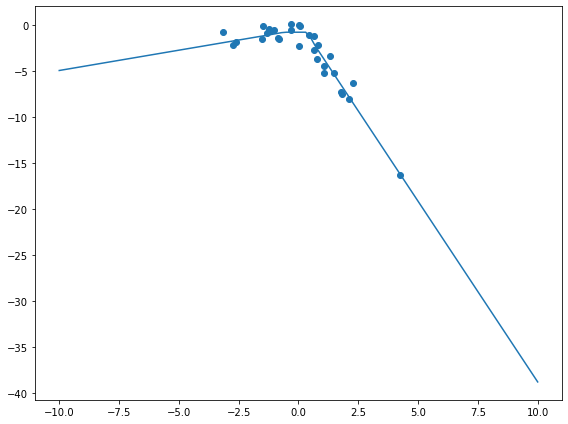

In [344]:
f, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, label='Targets w/ noise')
xs = torch.linspace(-10, 10, 100)
ax.plot(xs, data_generator_model(xs).detach(), label='Targets wo/ noise')
f.tight_layout()

# Model the Data

In [347]:
bnn = one_layer_bnn()
bnn.train()

opt = torch.optim.Adam(bnn.parameters(), lr=0.1)

for epoch in range(10000):
    opt.zero_grad()
    y_preds = bnn(x)
    loss = bnn.loss_function(y, y_preds)
    loss.backward()
    if epoch % 1000 == 0:
        print(f"The loss is : {loss.item()}")
    opt.step()

The loss is : 410.7856140136719
The loss is : 127.82720184326172
The loss is : 127.82797241210938
The loss is : 127.82779693603516
The loss is : 127.82738494873047
The loss is : 127.83746337890625
The loss is : 127.82902526855469
The loss is : 127.82809448242188
The loss is : 127.84980010986328
The loss is : 127.82770538330078


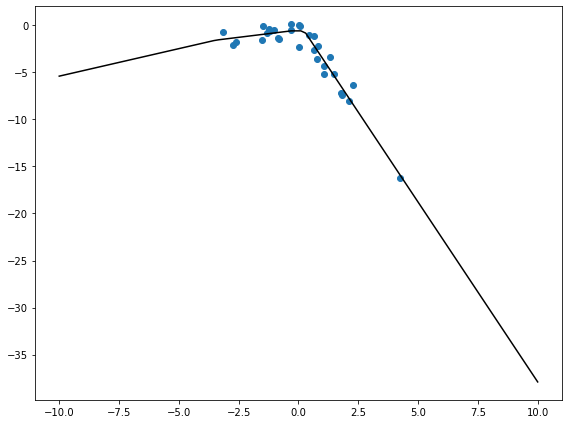

In [349]:
f, ax = plt.subplots(figsize=(8, 6))
xs = torch.linspace(-10, 10, 100)
bnn.eval()
ax.scatter(x, y, label='Truth')
ax.plot(xs, bnn(xs).detach(), 'k-', label='Model')
f.tight_layout()